# Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
import warnings

In [2]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

<h4>Implimenting Attention Model</h4>


In [3]:
#Reference : https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py

import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Data PreProcessing
<br>

In [4]:
#For our Model we are Using Amazon Fine reviews dataset

data=pd.read_csv("Reviews.csv",nrows=100000)

In [5]:
#Remove null values and dupicate values

data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [7]:
'''
As machine is unable to compute such contractions hence
we need to remove it
'''
contraction_mapping = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [8]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

#Text Preprocessing
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [9]:
#call the function for Reviews
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [10]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [11]:
#call the function fpr summaries 
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [12]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [13]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [14]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

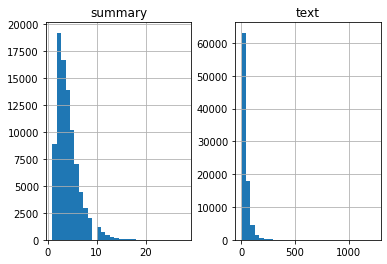

In [15]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()


In [16]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9425133841156297


In [17]:
max_text_len=30
max_summary_len=8

In [18]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [19]:
#For Embeddings we need Start tag and end tag for each sentence sepratly

df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

# Tokenization and Creaton of Vocabulary

In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [21]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [22]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.12054772517368
Total Coverage of rare words: 2.9537961717161627


In [23]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [24]:
x_voc

8438

In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [26]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.21782178217822
Total Coverage of rare words: 5.405320306947706


In [27]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [28]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(42453, 42453)

In [29]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)


ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Creation of model

GRU and LSTM both are better then Simple RNN.Overall LSTM is better then gru thus we selected LSTM for use.<br>

Bidirectional LSTM is slower but gives better result hence for Encoder Bidirectional LSTM is used.
<br>

for Encoder : Bidirecional Lstm is used<br>
For Decoder : Unidirectional LSTM is used<br>
<br>
Bahadanu Attention Model is used for picking up most likely sentence
<br>
Beam search is used as inference<br>


In [30]:
#Hyper Parameters

latent_dim = 300
embedding_dim=100
epochs = 50
batch_size = 128

In [31]:
from keras import backend as K 
K.clear_session()

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


from keras.layers import Dense,LSTM,Input,Activation,Add,TimeDistributed,Flatten,RepeatVector,Lambda,Multiply,Reshape

In [32]:
# Encoder side

encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#Bidirectional LSTM layer 1
encoder_LSTM1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_LSTM_rev1=LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.05,recurrent_dropout=0.4,go_backwards=True)
    
encoder_outputs1, state_h1, state_c1 = encoder_LSTM1(enc_emb)
encoder_outputsR1, state_hR1, state_cR1 = encoder_LSTM_rev1(enc_emb)
    
state_hfinal1=Add()([state_h1,state_hR1])
state_cfinal1=Add()([state_c1,state_cR1])


#Layer 2
encoder_LSTM = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_LSTM_rev=LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.05,recurrent_dropout=0.4,go_backwards=True)
    
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_outputs1)
encoder_outputsR, state_hR, state_cR = encoder_LSTM_rev(encoder_outputsR1)
    
state_hfinal=Add()([state_h,state_hR])
state_cfinal=Add()([state_c,state_cR])
encoder_outputs_final = Add()([encoder_outputs,encoder_outputsR])

encoder_states = [state_hfinal,state_cfinal]

'''
#encoder lstm layer 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm layer 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm layer 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)'''

'\n#encoder lstm layer 1\nencoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)\nencoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)\n\n#encoder lstm layer 2\nencoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)\nencoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)\n\n#encoder lstm layer 3\nencoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)\nencoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)'

In [33]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#decoder side embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#Unidirectional LSTM for Decoder
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=encoder_states)

In [34]:
#Bahadanu attention model for better accuracy

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs_final, decoder_outputs])

In [35]:
''' Concat attention input and decoder LSTM output before Producing 
    actual output'''
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [36]:
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      843800      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 30, 300), (N 481200      embedding[0][0]                  
______________________________________________________________________________________________

In [37]:
from IPython.display import Image
from keras.utils.vis_utils import plot_model

# Training of Model

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [39]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=1,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

324/324 [==============================] - 1323s 4s/step - loss: 2.8128 - val_loss: 2.5665


In [40]:
#Always save your weights to avoid training everytime
model.save_weights('summarization_weights.h5')

In [41]:
#Load the weights
model.load_weights('summarization_weights.h5')

In [42]:
#Creating Dictionary for target to source vocabulary
summ_index_word = y_tokenizer.index_word
text_index_word = x_tokenizer.index_word
summ_word_index = y_tokenizer.word_index

In [43]:
summ_word_index

{'sostok': 1,
 'eostok': 2,
 'great': 3,
 'good': 4,
 'the': 5,
 'best': 6,
 'not': 7,
 'for': 8,
 'love': 9,
 'coffee': 10,
 'and': 11,
 'it': 12,
 'my': 13,
 'tea': 14,
 'product': 15,
 'this': 16,
 'delicious': 17,
 'is': 18,
 'very': 19,
 'taste': 20,
 'but': 21,
 'yummy': 22,
 'excellent': 23,
 'to': 24,
 'of': 25,
 'dog': 26,
 'these': 27,
 'flavor': 28,
 'price': 29,
 'tasty': 30,
 'like': 31,
 'favorite': 32,
 'ever': 33,
 'in': 34,
 'too': 35,
 'loves': 36,
 'food': 37,
 'stuff': 38,
 'snack': 39,
 'awesome': 40,
 'so': 41,
 'yum': 42,
 'dogs': 43,
 'are': 44,
 'as': 45,
 'just': 46,
 'chocolate': 47,
 'them': 48,
 'with': 49,
 'healthy': 50,
 'wonderful': 51,
 'nice': 52,
 'free': 53,
 'perfect': 54,
 'better': 55,
 'you': 56,
 'on': 57,
 'treats': 58,
 'treat': 59,
 'tastes': 60,
 'no': 61,
 'really': 62,
 'tasting': 63,
 'quality': 64,
 'than': 65,
 'what': 66,
 'sweet': 67,
 'cup': 68,
 'hot': 69,
 'have': 70,
 'at': 71,
 'chips': 72,
 'buy': 73,
 'bad': 74,
 'amazing': 75

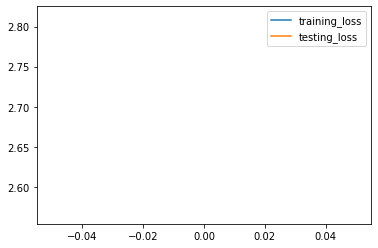

In [44]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='training_loss')
pyplot.plot(history.history['val_loss'], label='testing_loss')
pyplot.legend()
pyplot.show()

On Y axis we have loss for training and testing  and on x axis we have number of epochs. 

# Inference : Greedy Search

In [45]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs_final, state_hfinal, state_cfinal])

# Decoder setup
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

#Embedding at decoder side
dec_emb2= dec_emb_layer(decoder_inputs) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention Model
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [46]:
def generate_summary(input_seq):
    # Encoder output
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate an empty summary sequence of length 1
    summ_seq = np.zeros((1,1))
    
    # Initialize the first word with our start token
    summ_seq[0,0] = summ_word_index['sostok']
    
    
    generated_summary = ''
    while True:
        output_tokens, h, c = decoder_model.predict([summ_seq] + [e_out,e_h,e_c])
        
        # Predicted token
        predicted_token_index = np.argmax(output_tokens[0,-1,:])
        predicted_token = summ_index_word[predicted_token_index]
        
        if predicted_token != 'eostok':
            generated_summary += ' ' + predicted_token 
        
        # break if we reached the max length or received our end token
        if predicted_token == 'eostok' or len(generated_summary.split()) >= (max_summary_len -1):
            break
            
        # Update the summary seq
        summ_seq = np.zeros((1,1))
        summ_seq[0,0] = predicted_token_index
        
        # update internal states
        e_h, e_c= h,c
        
    return generated_summary

# Prediction 

In [51]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=summ_word_index['sostok']) and i!=summ_word_index['eostok']):
            newString=newString+summ_index_word[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+text_index_word[i]+' '
    return newString

In [53]:
for i in range(0,10):
    print("Text:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Projected summary:",generate_summary(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Text: got great course good belgian chocolates better 
Original summary: would like to give it stars but 
Projected summary:  great


Text: one best flavored coffees tried usually like flavored coffees one great serve company love 
Original summary: delicious 
Projected summary:  best coffee


Text: salt separate area pain makes hard regulate salt putting like salt go ahead get product 
Original summary: tastes ok packaging 
Projected summary:  great


Text: really like product super easy order online delivered much cheaper buying gas station stocking good long drives 
Original summary: turkey jerky is great 
Projected summary:  great


Text: best salad dressing delivered promptly quantities last vidalia onion dressing compares made oak hill farms sometimes find costco order front door want even orders cut shipping costs 
Original summary: my favorite salad dressing 
Projected summary:  great


Text: think sitting around warehouse long time took long time send got tea tasted like cardb

# EVALUATION

In [ ]:
#Ww will evaluate our Generated summary with the help of ROUGE Score

In [54]:
#pip install rouge

In [55]:
from rouge import Rouge 
rouge = Rouge()
for i in range(0,10):
    
    hypothesis = generate_summary(x_tr[i].reshape(1,max_text_len))
    reference = seq2summary(y_tr[i])
    scores = rouge.get_scores(hypothesis, reference)

In [57]:
print(scores)

[{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}}]


# Further Improvements

Implimentation of <b>pointer generator networks</b> for better results.

Implimenting <b>Beam Search</b> instead of Greedy search